In [1]:
import os
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.tools as tls #visualization
import plotly.figure_factory as ff #visualization
from plotly.offline import init_notebook_mode, plot,iplot

# from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, AgglomerativeClustering
# from sklearn.neighbors import kneighbors_graph
from sklearn import (manifold, decomposition)

init_notebook_mode(connected=True)

datadir = os.path.join('.','data2020', 'players_20.csv')

# Curación

## Curacion de los datos (variables de soporte)

Explicacion de las [features](https://www.fifauteam.com/fifa-20-attributes-guide/).
Utilizando las features analizadas en el notebook anterior seleccionamos las columnas a utilizar.
Establecemos una categoria numerica para mapear un campo categórico.

In [2]:
#######################################################################
cols2keep_obj = list()
cols2keep_num = list()

# Features generales
cols2keep_obj.append('short_name')
cols2keep_obj.append('club')
cols2keep_obj.append('player_positions')
cols2keep_obj.append('preferred_foot')
cols2keep_obj.append('team_position')

cols2keep_num.append('height_cm')
cols2keep_num.append('weight_kg')
cols2keep_num.append('overall')
cols2keep_num.append('work_rate')
cols2keep_num.append('shooting')
cols2keep_num.append('passing')
cols2keep_num.append('dribbling')
cols2keep_num.append('defending')
cols2keep_num.append('physic')

# Features relativas a un arquero
cols2keep_num.append('goalkeeping_diving')
cols2keep_num.append('goalkeeping_handling')
cols2keep_num.append('goalkeeping_kicking')
cols2keep_num.append('goalkeeping_reflexes')
cols2keep_num.append('goalkeeping_positioning')

# Features relativas a la capacidad de ataque
cols2keep_num.append('attacking_crossing')
cols2keep_num.append('attacking_finishing')
cols2keep_num.append('attacking_heading_accuracy')
cols2keep_num.append('attacking_short_passing')
cols2keep_num.append('attacking_volleys')

# Features relativas a las habilidades
cols2keep_num.append('skill_moves')
cols2keep_num.append('skill_dribbling')
cols2keep_num.append('skill_curve')
cols2keep_num.append('skill_fk_accuracy')
cols2keep_num.append('skill_long_passing')
cols2keep_num.append('skill_ball_control')

# Features relativas a la movilidad
cols2keep_num.append('movement_acceleration')
cols2keep_num.append('movement_sprint_speed')
cols2keep_num.append('movement_agility')
cols2keep_num.append('movement_reactions')
cols2keep_num.append('movement_balance')

# Features relativas a la potencia
cols2keep_num.append('power_shot_power')
cols2keep_num.append('power_jumping')
cols2keep_num.append('power_stamina')
cols2keep_num.append('power_strength')
cols2keep_num.append('power_long_shots')

# Features relativas a las soft skills
cols2keep_num.append('mentality_aggression')
cols2keep_num.append('mentality_interceptions')
cols2keep_num.append('mentality_positioning')
cols2keep_num.append('mentality_vision')
cols2keep_num.append('mentality_penalties')
cols2keep_num.append('mentality_composure')

# Features relativas a la defensa
cols2keep_num.append('defending_marking')
cols2keep_num.append('defending_standing_tackle')
cols2keep_num.append('defending_sliding_tackle')

#######################################################################
# Columnas con campos en NaN
cols2fix = list()
cols2fix.append('shooting')
cols2fix.append('passing')
cols2fix.append('dribbling')
cols2fix.append('defending')
cols2fix.append('physic')

# Regla de transformacion de work_rate
regla = dict()
regla['High/High'] = 4
regla['High/Medium'] = 3
regla['High/Low'] = 2
regla['Medium/High'] = 1 
regla['Medium/Medium'] = 0
regla['Medium/Low'] = -1
regla['Low/High'] = -2
regla['Low/Medium'] = -3
regla['Low/Low'] = -4

## Curación de los datos (ejecución)

Creamos el dataset, con las columnas seleccionadas anteriormente y hacemos una limpieza de los datos faltantes o inconsistentes.

In [3]:
#1. Cargamos el conjunto de datos fifa 2020
dfn = pd.read_csv(datadir)
dfn = dfn.sample(n=4000)

#2. Tomamos la metadata que nos interesa `cols2keep_obj` 
dfo = dfn[cols2keep_obj]

#3. Tomamos solo las columnas que nos interesan `cols2keep_num`
dfn = dfn[cols2keep_num]

#4. Se completan con cero las entradas de las columnas `cols2fix` para remover los NaN
dfn[cols2fix] = dfn[cols2fix].fillna(0)

#5. Se completan con "Undef" las entradas de la columna `team_position` para remover los NaN
dfn['work_rate'] = dfn.work_rate.apply(lambda x: regla[x])

#6. S convierte `work_rate` a categorica numérica en el rango [-4, 4]
dfo['team_position'] = dfo.team_position.fillna('Undef')

display(dfo.info())
display('####################')
display(dfn.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 8255 to 5122
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   short_name        4000 non-null   object
 1   club              4000 non-null   object
 2   player_positions  4000 non-null   object
 3   preferred_foot    4000 non-null   object
 4   team_position     4000 non-null   object
dtypes: object(5)
memory usage: 187.5+ KB


None

'####################'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 8255 to 5122
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   height_cm                   4000 non-null   int64  
 1   weight_kg                   4000 non-null   int64  
 2   overall                     4000 non-null   int64  
 3   work_rate                   4000 non-null   int64  
 4   shooting                    4000 non-null   float64
 5   passing                     4000 non-null   float64
 6   dribbling                   4000 non-null   float64
 7   defending                   4000 non-null   float64
 8   physic                      4000 non-null   float64
 9   goalkeeping_diving          4000 non-null   int64  
 10  goalkeeping_handling        4000 non-null   int64  
 11  goalkeeping_kicking         4000 non-null   int64  
 12  goalkeeping_reflexes        4000 non-null   int64  
 13  goalkeeping_positioning     40

None

In [4]:
dfo.head(5)

short_name              club player_positions preferred_foot  \
8255          H. Sacko       Denizlispor           RM, RW          Right   
16213  F. Pizzicanella  Atlético Tucumán               GK          Right   
1560        Juan Jesus              Roma           CB, LB           Left   
13472          S. Juma         Al Ain FC               CB          Right   
3378              Saúl  Deportivo Alavés               LB           Left   

      team_position  
8255            SUB  
16213           SUB  
1560            SUB  
13472           SUB  
3378            SUB

In [5]:
dfn.head(5)

height_cm  weight_kg  overall  work_rate  shooting  passing  dribbling  \
8255         183         82       67          0      65.0     55.0       69.0   
16213        183         84       58          0       0.0      0.0        0.0   
1560         185         83       76         -2      33.0     52.0       60.0   
13472        173         72       62          0      28.0     46.0       42.0   
3378         182         76       72          0      45.0     66.0       67.0   

       defending  physic  goalkeeping_diving  ...  power_long_shots  \
8255        27.0    70.0                   8  ...                65   
16213        0.0     0.0                  57  ...                 9   
1560        76.0    78.0                  12  ...                35   
13472       58.0    69.0                  12  ...                21   
3378        70.0    64.0                   7  ...                65   

       mentality_aggression  mentality_interceptions  mentality_positioning  \
8255                     67                       26                     64   
16213                    20                       12                      8   
1560                     88                       76                     35   
13472                    71                       61                     33   
3378                     59                       70                     49   

       mentality_vision  mentality_penalties  mentality_composure  \
8255                 54                   60                   49   
16213                20                   15                   37   
1560                 34                   37                   73   
13472                45                   36                   50   
3378                 53                   43                   55   

       defending_marking  defending_standing_tackle  defending_sliding_tackle  
8255                  24                         25                        19  
16213                 15                         12                        10  
1560                  76                         78                        75  
13472                 55                         60                        58  
3378                  69                         71                        72  

[5 rows x 44 columns]

Para poder visualizar los datos utilizamos tsne, que nos permite proyectarlos en menos dimensiones mantiendo la distancia entre ellos. en este caso trasnformamos el espacio de 44 dimensiones en un espacio de 2 dimensión (n_components=2)

In [6]:
time_start = time.time()

tsne = manifold.TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000, n_jobs=2)
X_tsne = tsne.fit_transform(dfn)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.020s...
[t-SNE] Computed neighbors for 4000 samples in 1.779s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 14.299777
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.139030
[t-SNE] KL divergence after 1000 iterations: 1.569792
t-SNE done! Time elapsed: 57.097089767456055 seconds


A continuación se muestran los datos de 10 jugadores en función de las nuevas componentes que reunen las características de las 44 dimensiones anteriores

In [7]:
X_tsne[3990:4000]

array([[ 12.615494  ,  -0.41781953],
       [-22.007427  , -63.873676  ],
       [  7.029847  ,  -8.436853  ],
       [ 47.669926  ,  11.21761   ],
       [-26.737902  ,  15.596007  ],
       [  0.1565582 ,  -2.185193  ],
       [ 12.72091   ,  -8.637708  ],
       [-22.968218  , -11.770971  ],
       [  9.538102  , -23.77508   ],
       [ 29.137447  ,  -2.9289582 ]], dtype=float32)

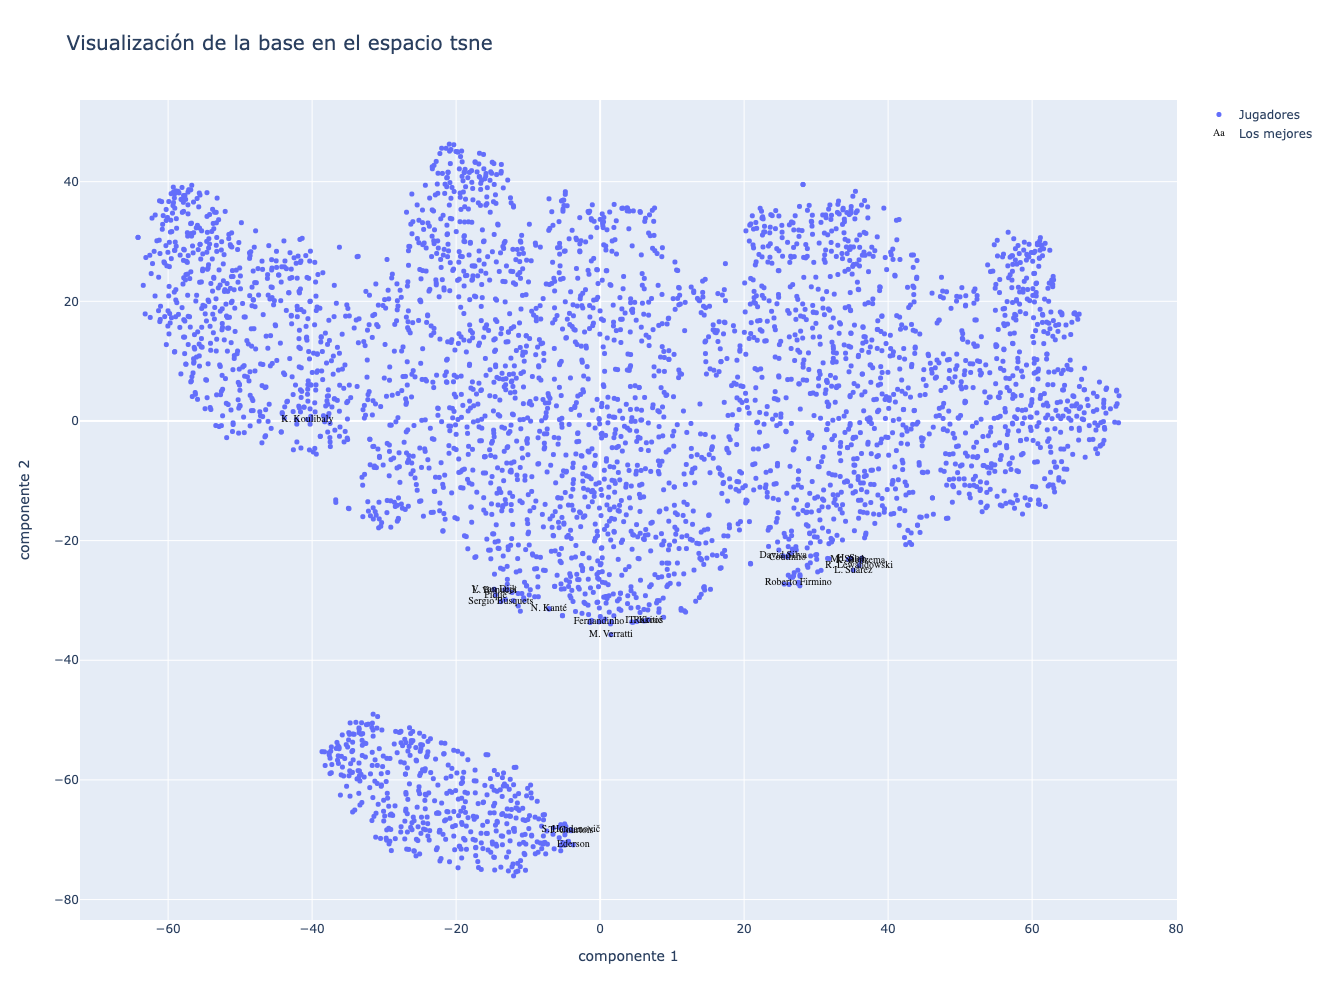

In [8]:
data=[]
bool_crack=dfn.overall > 85

#graficamos los datos en el espacio transformado: las dos componentes tsne

graf1 = go.Scatter(x=X_tsne[:,0], y=X_tsne[:,1],
                   name='Jugadores',
                   mode='markers',
                   text=dfo[['club', 'team_position']].apply(lambda x:f'{x.club} - {x.team_position}', axis=1),
                   marker=dict(size=5))

crack =go.Scatter(x=X_tsne[bool_crack,0], y=X_tsne[bool_crack,1],
                  name='Los mejores',
                  text=dfo.loc[bool_crack,'short_name'],
                  textfont=dict(family='sans serif',size=10,color='black'),
                  opacity=0.9,
                  mode='text')

data=[graf1, crack]

layout = go.Layout(title="Visualización de la base en el espacio tsne",titlefont=dict(size=20),
                   xaxis=dict(title='componente 1'),
                   yaxis=dict(title='componente 2'),
                   autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)
# plot(fig)

Por lo que se observa en la gráfica a primera vista, los jugadores se estarían agrupando por posición en el equipo. El grupo minoritario en su mayoría está conformado por GK y SUB exclusivamente

In [9]:
dfo[['short_name','player_positions', 'team_position']]

short_name player_positions team_position
8255          H. Sacko           RM, RW           SUB
16213  F. Pizzicanella               GK           SUB
1560        Juan Jesus           CB, LB           SUB
13472          S. Juma               CB           SUB
3378              Saúl               LB           SUB
...                ...              ...           ...
12002      S. Carrasco          CDM, CM           SUB
4031      S. Hernández     CAM, CM, CDM           CAM
8379      G. Rodríguez               LB           SUB
7381          M. Albæk          CDM, CM            CM
5122     B. Aouacheria           RW, LW            RW

[4000 rows x 3 columns]

Creamos una nueva columna con 4 categorias de posiciones:

In [10]:
def pos_tranf(pp, tp):
    forwards = set(['RF', 'ST', 'LW', 'LF', 'RS', 'LS', 'RM', 'LM','RW'])
    midfielders = set(['RCM','LCM','LDM','CAM','CDM','LAM','RDM','CM','RAM','CF'])
    defenders = set(['RCB','CB','LCB','LB','RB','RWB','LWB'])
    goalkeepers = set(['GK'])
    
    tocheck = set(pp) | set(tp)
    
    if  tocheck & forwards:
        return 'Forward'
    
    elif tocheck & midfielders:
        return 'Midfielder'
    
    elif tocheck & defenders:
        return 'Defender'
    
    elif tocheck & goalkeepers:
        return 'GoalKeeper'
    
    else:
        return 'NaN'

In [11]:
dfo['position'] = dfo.apply(lambda x: pos_tranf(x.player_positions.split(', '), x.team_position.split(', ')), axis=1)
display(dfo.head(10))
display(dfo.position.value_counts())

short_name                club player_positions preferred_foot  \
8255          H. Sacko         Denizlispor           RM, RW          Right   
16213  F. Pizzicanella    Atlético Tucumán               GK          Right   
1560        Juan Jesus                Roma           CB, LB           Left   
13472          S. Juma           Al Ain FC               CB          Right   
3378              Saúl    Deportivo Alavés               LB           Left   
17770       Sun Weizhe    Beijing Renhe FC              CDM          Right   
2905        Pere Milla            Elche CF      CAM, RM, LM           Left   
14418         P. Nsiah  Academica Clinceni          ST, CAM          Right   
240         M. Kovačić             Chelsea               CM          Right   
15804          R. Peña           Querétaro               RB          Right   

      team_position    position  
8255            SUB     Forward  
16213           SUB  GoalKeeper  
1560            SUB    Defender  
13472           SUB    Defender  
3378            SUB    Defender  
17770           RES  Midfielder  
2905            CAM     Forward  
14418           RAM     Forward  
240             SUB  Midfielder  
15804           RES    Defender

Forward       1518
Defender      1092
Midfielder     941
GoalKeeper     449
Name: position, dtype: int64

Las variables que usamos para el scatterplot son las 2 componentes dadas por tSNE. Diferenciamos usando vectores booleanos: para cada posición y si es un crack

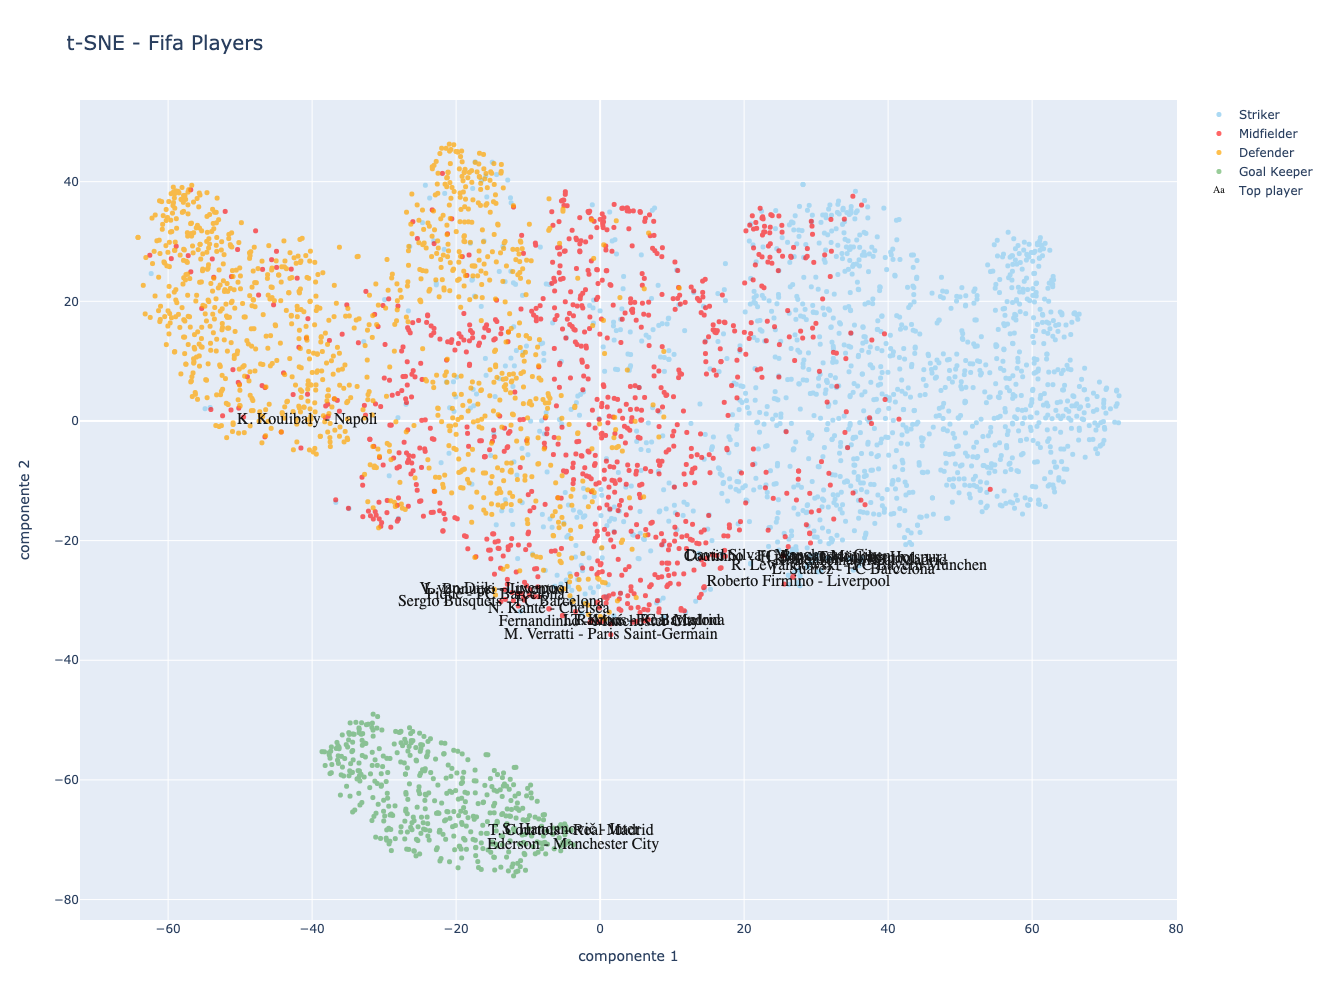

In [12]:
bool_striker = dfo["position"] == 'Forward'
bool_midfielder = dfo["position"] == 'Midfielder'
bool_defender = dfo["position"] == 'Defender'
bool_gk = dfo["position"] == 'GoalKeeper'

bool_crack=dfn["overall"] > 85

palette=['navy','red','#A2D5F2','orange','green','pink']  

striker = go.Scatter(x=X_tsne[bool_striker,0], y=X_tsne[bool_striker,1],
                    name='Striker',
                    text=dfo.loc[bool_striker, ['club', 'short_name']].apply(lambda x:f'{x.short_name} - {x.club}', axis=1),
                    opacity=0.9,
                    marker=dict(color=palette[2],size=5),
                    mode='markers')

midfielder = go.Scatter(x=X_tsne[bool_midfielder,0], y=X_tsne[bool_midfielder,1],
                       name='Midfielder',
                       text=dfo.loc[bool_midfielder, ['club', 'short_name']].apply(lambda x:f'{x.short_name} - {x.club}', axis=1),
                       opacity=0.6,
                       marker=dict(color=palette[1],size=5),
                       mode='markers')

defender = go.Scatter(x=X_tsne[bool_defender,0], y=X_tsne[bool_defender,1],
                     name='Defender',
                     text=dfo.loc[bool_defender, ['club', 'short_name']].apply(lambda x:f'{x.short_name} - {x.club}', axis=1),
                     opacity=0.7,
                     marker=dict(color=palette[3],size=5),
                     mode='markers')

gk = go.Scatter(x=X_tsne[bool_gk,0], y=X_tsne[bool_gk,1],
                name='Goal Keeper',
                text=dfo.loc[bool_gk, ['club', 'short_name']].apply(lambda x:f'{x.short_name} - {x.club}', axis=1),
                opacity=0.4,
                marker=dict(color=palette[4],size=5),
                mode='markers')

crack = go.Scatter(x=X_tsne[bool_crack,0], y=X_tsne[bool_crack,1],
                   name='Top player',
                   text=dfo.loc[bool_crack, ['club', 'short_name']].apply(lambda x:f'{x.short_name} - {x.club}', axis=1),
                   textfont=dict(family='sans serif',color='black',size=16),
                   opacity=0.9,
                   mode='text')

data=[striker,midfielder,defender,gk,crack]

layout = go.Layout(title="t-SNE - Fifa Players", 
                   titlefont=dict(size=20),
                   xaxis=dict(title='componente 1'),
                   yaxis=dict(title='componente 2'),
                   autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)
# plot(fig)

Como conclusión podemos observar en las gráficas de 2D que los que claramente se diferencian en una isla aparte, son los arqueros. Por lo contrario en la otra isla se diferencian más claramente los defensores y los delanteros, que son los que se encuentran en los extremos respectivamente. Aún así ciertos jugadores se encuentran en una posición más cercana al grupo contrario al que fueron categorizados. Esta separación es correcta dado que los delanteros y defensores tienen claras cualidades que los diferencian entre sí. Por otro lado, los que son muy dificiles de diferenciar en la mismka isla son los mediocampistas. Dado que los mediocampistas pueden, a su vez, ser atacantes o defensivos. Y, a su vez, un mismo jugador puede reunir ambas condiciones dentro del mediocampo  

## PCA

Para reducción de dimensión de n dimensiones a m dimensiones siendo m menor a n. En el mejor de los casos , se reduce el "ruido" en los hiperparámetros a utilizar y mantiendo la mayor varianza entre los mismos. Actualmente contamos con 44 dimensiones

La descomposición PCA del sklearn centra los datos pero no los normaliza, por eso necesitamos standarizar primero


In [13]:
from sklearn import preprocessing

std_scale=preprocessing.StandardScaler().fit(dfn)
X_scaled=std_scale.transform(dfn) 
X_scaled.shape

(4000, 44)

En la descomposición podemos elegir n_components (dimensión a la que queremos reducirnos) para quedarnos con una cantidad chica de componentes la idea es que sean "bastante" menos que la dimensión de lo datos pero que describan un buen porcentaje de la dispersión de los datos

In [14]:
from sklearn import decomposition
pca=decomposition.PCA(n_components=4) #elegimos 2, 3 o 4 pero pueden ser más, 

pca.fit(X_scaled) #input data is centered but not scaled for each feature before applying the SVD

# proporción de varianza
print('proporción de varianza por componente: ', pca.explained_variance_ratio_)
# proporción de varianza acumulada
print ('proporción de varianza por componente acumulada: ', pca.explained_variance_ratio_.cumsum())

X_projected=pca.transform(X_scaled) #numpy array
print ('tamaño de los datos: ', X_projected.shape)

proporción de varianza por componente:  [0.54205203 0.13825686 0.08756423 0.051827  ]
proporción de varianza por componente acumulada:  [0.54205203 0.68030889 0.76787312 0.81970012]
tamaño de los datos:  (4000, 4)


El siguiente gráfico muestra la composición de los pesos de las dos primeras componentes principales. Es decir cómo influye cada dimensión en las componentes nuevas. De esta forma se puede ver a qué variable está más asociada cada componente

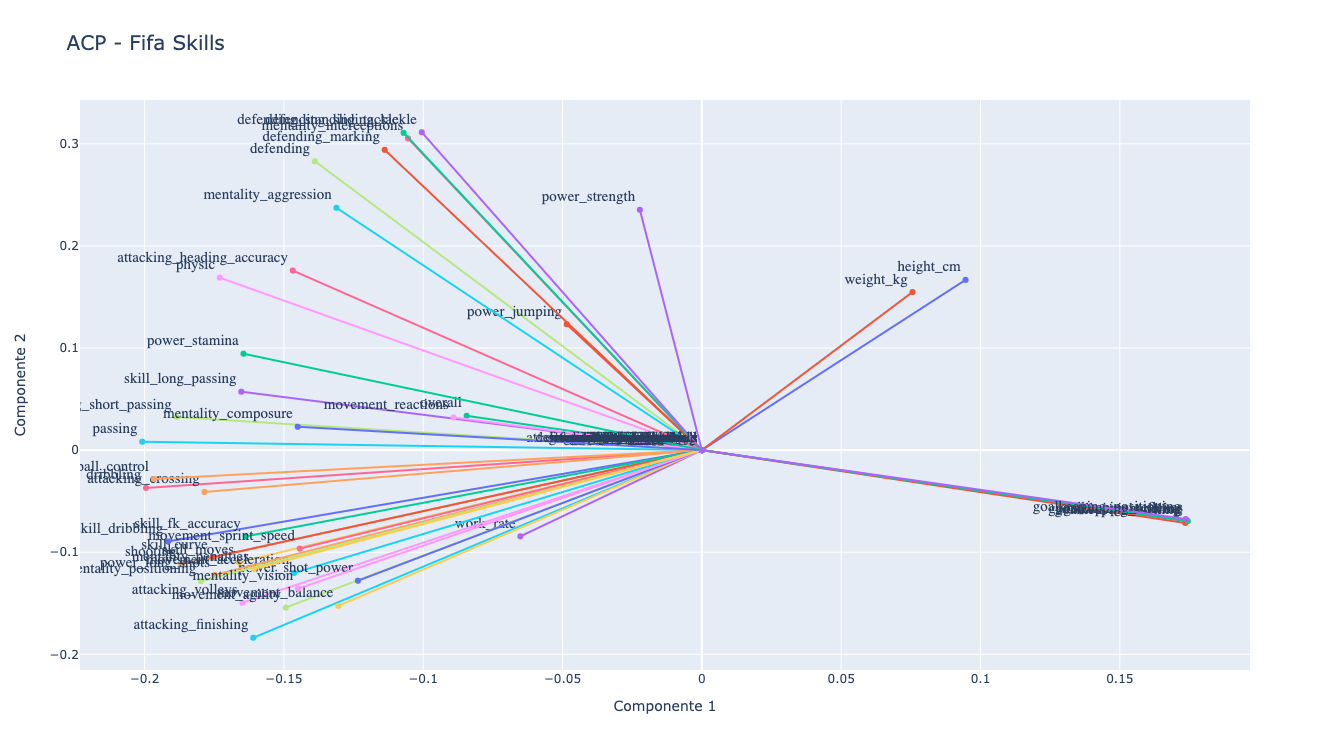

In [15]:
#Graph 1
pcs=pca.components_ 

data=[]

for i, (x,y) in enumerate(zip(pcs[0,:],pcs[1,:])):
    graph=go.Scatter(x=[0,x],y=[0,y],text=dfn.columns[i],
                     mode='lines+markers+text',textposition='top left',textfont=dict(family='sans serif',size=15))
    data.append(graph)

layout = go.Layout(title="ACP - Fifa Skills",titlefont=dict(size=20),
            xaxis=dict(title='Componente 1'),
            yaxis=dict(title='Componente 2'),
            autosize=False, width=1050,height=750,
            showlegend=False)

fig = go.Figure(data=data, layout=layout)

iplot(fig)
# plot(fig)

Se crea el jugador perfecto para ver a donde se ubica en nuestra visualización, se lo agrega a los datos normalizados y a las componentes ya calculadas (sin usarlo).

In [16]:
MachineGunDataDict={'short_name':'MachineGun'} # club player_positions preferred_foot team_position

MachineGunSkillsDict={'overall':99}
for skills in dfn.columns:
    MachineGunSkillsDict[skills]=99
    
#Lo agregamos a la base:
dfn=dfn.append(MachineGunSkillsDict,ignore_index=True)
dfo=dfo.append(MachineGunDataDict,ignore_index=True)
X_scaled=std_scale.transform(dfn) # volvemos a normalizar con el dato agregado 
#pero con la normalización de la base sin el dato nuevo
X_projected=pca.transform(X_scaled) # volvemos a proyectar pero con el dato nuevo

Teniendo como referencia al jugador perfecto MachineGun, podemos establecer hacia dónde deberían dirigirse los jugadores con mejores cualiades deportivas. Necesitamos esta referencia porque al ser componentes nuevas, no tenemos idea de cómo deberían distribuirse los datos sobre ellas.

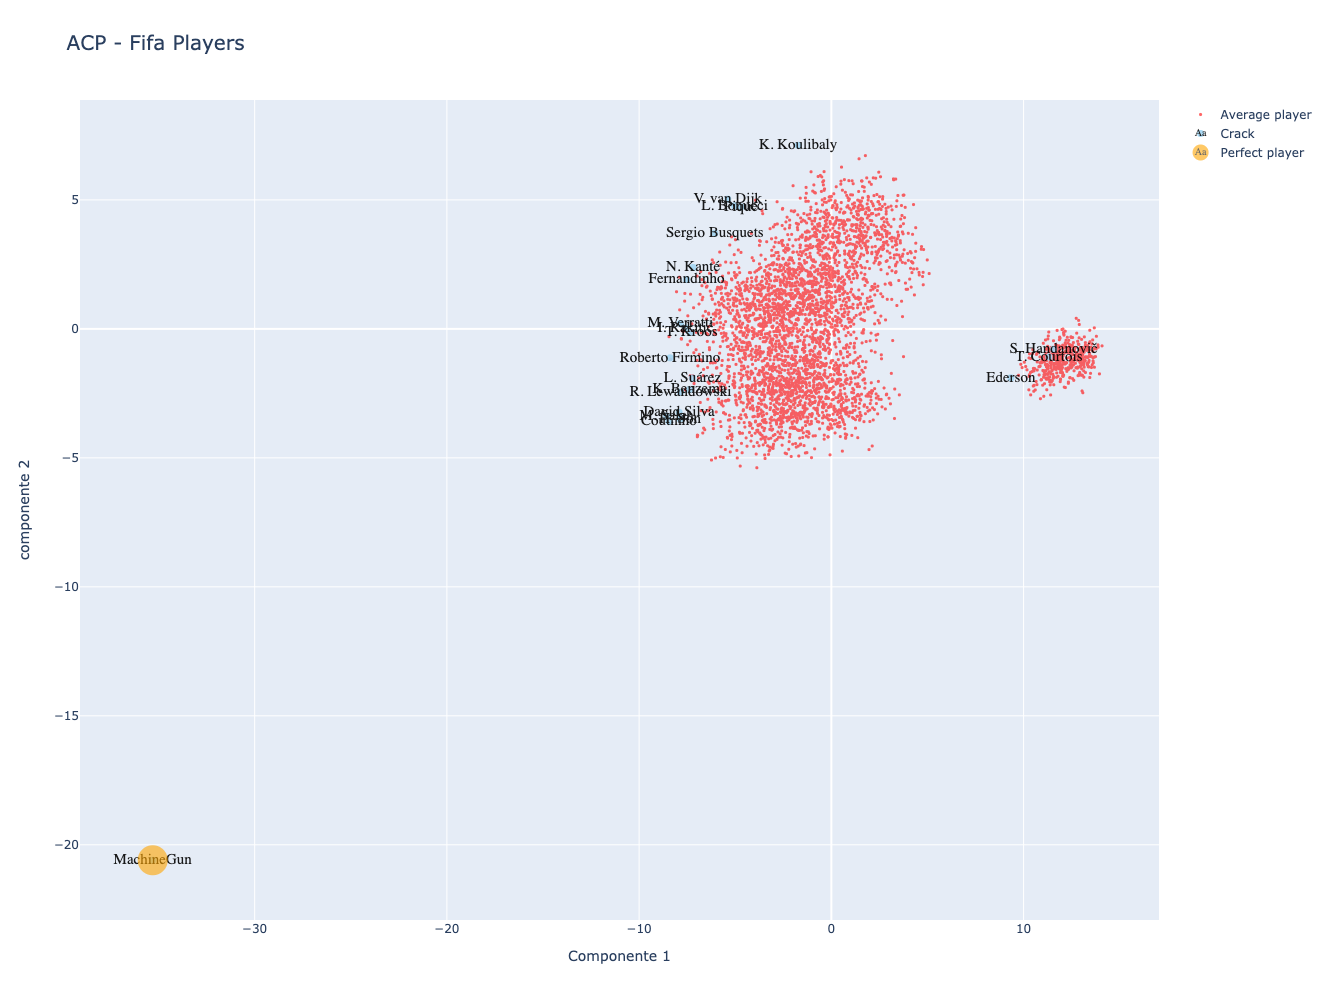

In [17]:
#Graph 2
#Choose your player
recherche_joueur=dfo["short_name"]=='L. Messi'

bool_crack=dfn["overall"] > 85
bool_no_crack=dfn["overall"]<86
bool_machinegun=dfo["short_name"]=='MachineGun'

palette=['navy','red','#A2D5F2','orange','green','pink']  
data=[]

acp_crack =go.Scatter(x=X_projected[bool_crack,0], y=X_projected[bool_crack,1],name='Crack',
                       text=dfo.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=15,color='black'),
                      opacity=0.9,marker=dict(color=palette[2],size=7),mode='markers+text')

acp_no_crack =go.Scatter(x=X_projected[bool_no_crack,0], y=X_projected[bool_no_crack,1],name='Average player',
                          text=dfo.loc[bool_no_crack,'short_name'],
                         opacity=0.6,marker=dict(color=palette[1],size=3),mode='markers')

acp_machinegun =go.Scatter(x=X_projected[bool_machinegun,0], y=X_projected[bool_machinegun,1],name='Perfect player',
                           textfont=dict(family='sans serif',size=20,color='black'),
                           opacity=0.6,marker=dict(color=palette[3],size=30),mode='markers+text')


joueur_recherche =go.Scatter(x=X_projected[recherche_joueur,0], y=X_projected[recherche_joueur,1],name='Searched player',
                            text=dfo.loc[recherche_joueur,'short_name'],
                            textfont=dict(family='sans serif',size=20,color='black'),
                           opacity=1,marker=dict(color=palette[4],size=40),mode='markers+text')

data=[acp_no_crack,acp_crack,acp_machinegun,joueur_recherche]

layout = go.Layout(title="ACP - Fifa Players",titlefont=dict(size=20),
                xaxis=dict(title='Componente 1'),
                yaxis=dict(title='componente 2'),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)
# plot(fig)

En la siguiente gráfica se seleccionan 2 equipos para comparar sus jugadores ya teniendo una noción de hacia dónde deberían dirigirse los mejores resultados. De esta forma, destacamos que el Liverpool cuanta con más jugadores con mejor desempeño que el Manchester

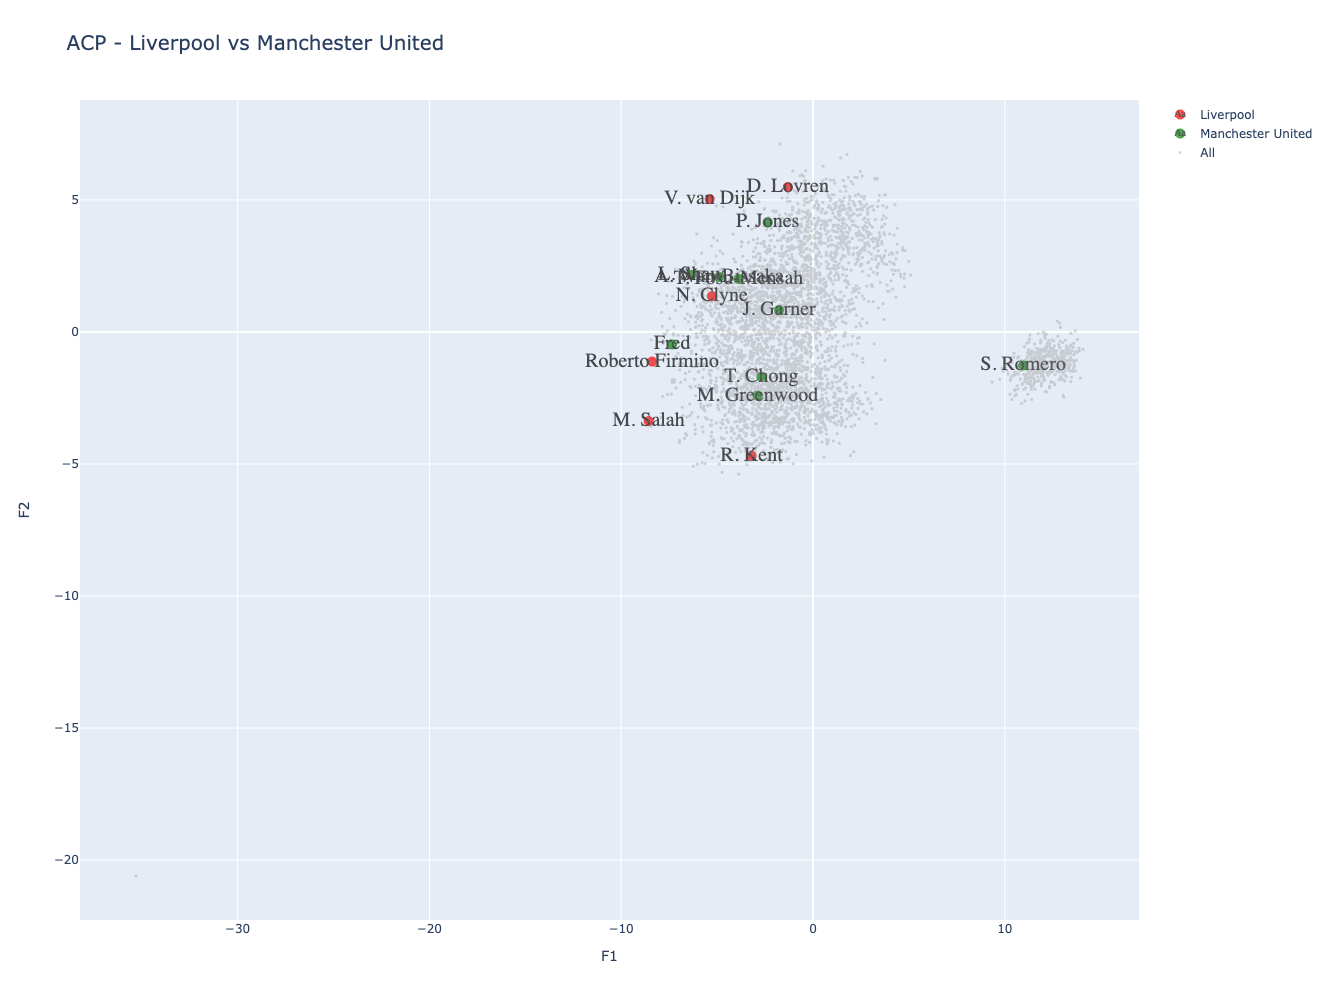

In [18]:
teamA='Liverpool'
teamB='Manchester United'

bool_teamA=dfo["club"]==teamA
bool_teamB=dfo["club"]==teamB

palette=['navy','red','#A2D5F2','orange','green','pink','grey']  
data=[]

acp_teamA =go.Scatter(x=X_projected[bool_teamA,0], y=X_projected[bool_teamA,1],name=teamA,
                      text=dfo.loc[bool_teamA,'short_name'],
                      textfont=dict(family='sans serif',size=20,color='black'),
                      opacity=0.7,marker=dict(color=palette[1],size=10),mode='markers+text')

acp_teamB =go.Scatter(x=X_projected[bool_teamB,0], y=X_projected[bool_teamB,1],name=teamB,
                      text=dfo.loc[bool_teamB,'short_name'],
                      textfont=dict(family='sans serif',size=20,color='black'),
                      opacity=0.7,marker=dict(color=palette[4],size=10),mode='markers+text')

acp_all =go.Scatter(x=X_projected[:,0], y=X_projected[:,1],name='All',
                         text=dfo.loc[:,'short_name'],
                         opacity=0.3,marker=dict(color=palette[6],size=3),mode='markers')


data=[acp_teamA,acp_teamB,acp_all]

layout = go.Layout(title="ACP - {} vs {}".format(teamA,teamB),titlefont=dict(size=20),
                xaxis=dict(title='F1'),
                yaxis=dict(title='F2'),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)
# plot(fig)